In [1]:
import os
from dotenv import load_dotenv
load_dotenv() 

True

In [2]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os

# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define root domain to crawl
domain = "openai.com"
full_url = "https://openai.com/"

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

# Function to get the hyperlinks from a URL
def get_hyperlinks(url):
    
    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            
            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))


def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Save text from the url to a <url>.txt file
        with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")
            
            # Otherwise, write the text to the file in the text directory
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

crawl(full_url)

https://openai.com/
https://openai.com/careers
https://openai.com/blog/openai-residency
https://openai.com/blog/openai-residency#content
https://openai.com/blog?topics=announcements
https://openai.com/blog/how-openai-is-approaching-2024-worldwide-elections
https://openai.com/policies/usage-policies
https://openai.com/policies/usage-policies#content
https://openai.com/policies/sharing-publication-policy
https://openai.com/policies/coordinated-vulnerability-disclosure-policy
https://openai.com/policies/coordinated-vulnerability-disclosure-policy#content
https://openai.com/security.txt
https://openai.com/policies/sharing-publication-policy#content
https://openai.com/policies/terms-of-use
http://openai.com/policies/eu-terms-of-use
https://openai.com/form/model-withdrawal
https://openai.com/form/model-withdrawal#content
https://openai.com/policies/eu-terms-of-use#content
https://openai.com/policies/service-terms
https://openai.com/policies/service-terms#content
https://openai.com/blog/opena

In [3]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [4]:
import pandas as pd

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

/tmp/ipykernel_3499/2931785837.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text
0,research?authors=ariel herbert voss,research?authors=ariel herbert voss. Research...
1,careers customer success manager 3,careers customer success manager 3. Customer ...
2,five,five. OpenAI Five defeats Dota 2 world champi...
3,research?authors=jacob hilton,research?authors=jacob hilton. Research index...
4,policies jun 2023 privacy policy#content,policies jun 2023 privacy policy#content. Pri...


<AxesSubplot: >

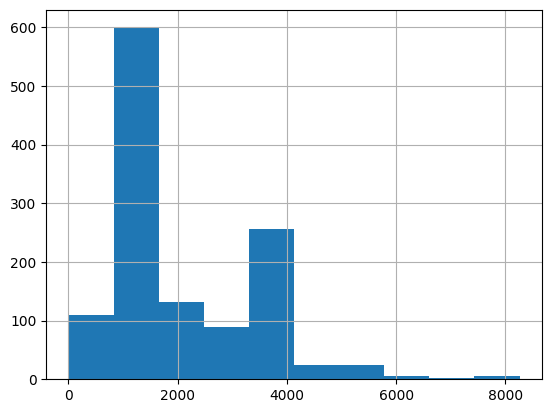

In [5]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [6]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    # Add the last chunk to the list of chunks
    if chunk:
        chunks.append(". ".join(chunk) + ".")

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<AxesSubplot: >

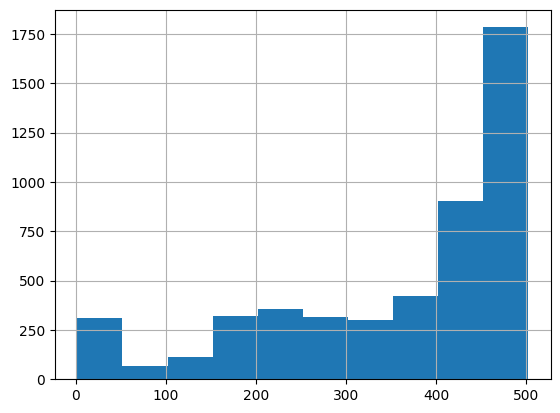

In [7]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [8]:
import os
from openai import OpenAI

client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)

df['embeddings'] = df.text.apply(lambda x: client.embeddings.create(input=x, model='text-embedding-ada-002').data[0].embedding)

df.to_csv('processed/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,research?authors=ariel herbert voss.,11,"[-0.007740546949207783, -0.0054871877655386925..."
1,BartlettÂ (1)Mohammad BavarianÂ (2)Alexandre...,434,"[0.001631682156585157, 0.0006636836915276945, ..."
2,EfrosÂ (1)Tyna EloundouÂ (3)Ãlfar Erlingsso...,195,"[0.00284423865377903, -0.003469044342637062, 0..."
3,RobinsonÂ (1)Nick RyderÂ (2)Ruslan Salakhutd...,215,"[0.0025212429463863373, -0.0010925385868176818..."
4,careers customer success manager 3. Customer ...,321,"[0.018410813063383102, -0.025261348113417625, ..."


In [9]:
import pandas as pd
import numpy as np
from ast import literal_eval

# 自定义的余弦相似度函数
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# 读取嵌入向量数据
df = pd.read_csv('processed/embeddings.csv', index_col=0)

# 将嵌入向量字符串转换为 numpy 数组
df['embeddings'] = df['embeddings'].apply(literal_eval).apply(np.array)

# 显示 DataFrame 的前几行
df.head()


,text,n_tokens,embeddings
0,research?authors=ariel herbert voss.,11,"[-0.007740546949207783, -0.0054871877655386925..."
1,BartlettÂ (1)Mohammad BavarianÂ (2)Alexandre...,434,"[0.001631682156585157, 0.0006636836915276945, ..."
2,EfrosÂ (1)Tyna EloundouÂ (3)Ãlfar Erlingsso...,195,"[0.00284423865377903, -0.003469044342637062, 0..."
3,RobinsonÂ (1)Nick RyderÂ (2)Ruslan Salakhutd...,215,"[0.0025212429463863373, -0.0010925385868176818..."
4,careers customer success manager 3. Customer ...,321,"[0.018410813063383102, -0.025261348113417625, ..."


In [13]:
def create_context(question, df, max_len=800, size="ada"):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    q_response = client.embeddings.create(input=question, model='text-embedding-ada-002')
    q_embeddings = q_response.data[0].embedding


    df['distances'] = df['embeddings'].apply(lambda emb: cosine_similarity(q_embeddings, emb))

    returns = []
    cur_len = 0


    for i, row in df.sort_values('distances', ascending=True).iterrows():
        cur_len += row['n_tokens'] + 4
        if cur_len > max_len:
            break
        returns.append(row["text"])


    return "\n\n###\n\n".join(returns)
def answer_question(df, model="davinci-002", question="Am I allowed to publish model outputs to Twitter, without a human review?", max_len=1800, size="ada", debug=True, max_tokens=100, stop_sequence="\n"):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(question, df, max_len=max_len, size=size)
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        response = client.completions.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say 'I don't know'\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response.choices[0].text.strip()
    except Exception as e:
        print(e)
        return ""



In [21]:
answer_question(df, question="What day is it today?")

Context:
Speed-ups compared to cuSPARSE were even larger for the tested levels of sparsity.Using the kernelsBelow we show some example code for performing sparse matrix multiplication inÂ Tensorflow.from blocksparse.matmul import BlocksparseMatMul import tensorflow as tf import numpy as np hidden_size = 4096 block_size = 32 minibatch_size = 64 # Create a (random) sparsity pattern sparsity = np.random.randint(2, size=(hidden_size//block_size,hidden_size//block_size)) # Initialize the sparse matrix multiplication object bsmm = BlocksparseMatMul(sparsity, block_size=block_size) # Input to graph x = tf.placeholder(tf.float32, shape=[None, hidden_size]) # Initialize block-sparse weights w = tf.get_variable("w", bsmm.w_shape, dtype=tf.float32) # Block-sparse matrix multiplication y = bsmm(x, w) # Run sess = tf.InteractiveSession() sess.run(tf.global_variables_initializer()) result = sess.run([y], feed_dict = {x: np.ones((minibatch_size,hidden_size), dtype='float32')}) print(result)nullSmall-

"I don't know"

In [17]:
answer_question(df, question="What are our newest models?")

Context:
User def fibonacci(num): Â Â Â Â if num <= 1: Â Â Â Â Â Â Â Â return num Â Â Â Â else: Â Â Â Â Â Â Â Â return fibonacci(num-1) + fibonacci(num-2) print(fibonacci(10)) User Rename the function to fib. OAIAssistant def fib(num): Â Â Â Â if num <= 1: Â Â Â Â Â Â Â Â return num Â Â Â Â else: Â Â Â Â Â Â Â Â return fib(num-1) + fib(num-2) print(fib(10)) AuthorsOpenAI View all articlesResearchOverviewIndexGPT-4DALLÂ·E 3APIOverviewPricingDocsChatGPTOverviewTeamEnterprisePricingTry ChatGPTCompanyAboutBlogCareersCharterSecurityCustomer storiesSafetyOpenAI Â© 2015âââ2024Terms & policiesPrivacy policyBrand guidelinesSocialTwitterYouTubeGitHubSoundCloudLinkedInBack to top .

###

User def fibonacci(num): Â Â Â Â if num <= 1: Â Â Â Â Â Â Â Â return num Â Â Â Â else: Â Â Â Â Â Â Â Â return fibonacci(num-1) + fibonacci(num-2) print(fibonacci(10)) User Rename the function to fib. OAIAssistant def fib(num): Â Â Â Â if num <= 1: Â Â Â Â Â Â Â Â return num Â Â Â Â else: Â Â Â Â Â Â Â Â ret

'GPT-3, GPT-2, GPT-2-117M, GPT-2-345M, GPT-2-774M, GPT-2-1.5B, GPT-2-1.5B-XXL, GPT-2-1.5B-XXL-XXL, GPT-2-1.5B-XXL-XXL-XXL, GPT-2-1.5'

In [19]:
answer_question(df, question="Where is the headquater of OpenAI?")

Context:
Ask just one question at a time.Â Tell me the learning level of your students (grade level, college, or professional).Â What topic or concept do you want to explain?Â How does this particular concept or topic fit into your curriculum and what do students already know about the topic?Â What do you know about your students that may to customize the lecture? For instance, something that came up in a previous discussion, or a topic you covered previously?Â ï»¿Using this information give the teacher a clear and simple 2-paragraph explanation of the topic, 2 examples, and an analogy. Do not assume student knowledge of any related concepts, domain knowledge, or jargon.Â Once you have provided the explanation, examples, and analogy, ask the teacher if they would like to change or add anything to the explanation. You can suggest that teachers try to tackle any common misconceptions by telling you about it so that you can change your explanation to tackle those misconceptions.C. Help st

'San Francisco, California'